<a href="https://colab.research.google.com/github/jorgeerrz/mistaken_mice/blob/master/mistaken_mice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mistaken Mice notebook

2020 NMA academy project, mistaken mice group, pod 173 antique cicada

# Import packages and functions

In [1]:
# to import the functions we wrote, clone the git repo
!git clone https://github.com/jorgeerrz/mistaken_mice.git
%cd mistaken_mice
#alternatively, run the notebook locally, then just comment the lines above

# from filter import *
# from summarise_dataset import *
# from PCA_fun import neurons_PCA
# from GLM import *

%load_ext autoreload
%autoreload 2

Cloning into 'mistaken_mice'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 197 (delta 110), reused 142 (delta 61), pack-reused 0
Receiving objects: 100% (197/197), 1.45 MiB | 11.00 MiB/s, done.
Resolving deltas: 100% (110/110), done.
/content/mistaken_mice


In [33]:
from filter import *
from summarise_dataset import *
from PCA_fun import neurons_PCA
from GLM import *
from rebin import *

# Loading of Steinmetz data

In [3]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)


In [4]:
# skip if you already downloaded the data
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [5]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


# Filter the data

In [ ]:
# need to loop over all sessions to pass as input to summarise_data function in next step
first_session_filtered_VISp = filter_spikes(alldat,0,'VISp') 
first_session_filtered = filter_spikes(alldat,0) 
print(np.shape(first_session_filtered['spks']))

(734, 10, 250)


# Summarise the filtered data

{'n_neurons': array([ 734., 1070.,  619., 1769., 1077., 1169.,  584., 1156.,  788.,
        1172.,  857.,  698.,  983.,  756.,  743.,  474.,  565., 1089.,
         606.,  899.,  578.,  646., 1268., 1337.,  885., 1056.,  563.,
         549.,  750.,  942.,  977.,  522.,  613.,  781.,  795.,  680.,
        1055.,  805., 1348.]),
 'n_trials': array([214., 251., 228., 249., 254., 290., 252., 250., 372., 447., 342.,
        340., 300., 268., 404., 280., 224., 316., 247., 235., 124., 444.,
        151., 187., 261., 178., 253., 142., 128., 143., 237., 260., 191.,
        296., 311., 258., 181., 199., 343.]),
 'n_timebins': array([250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250., 250.])}

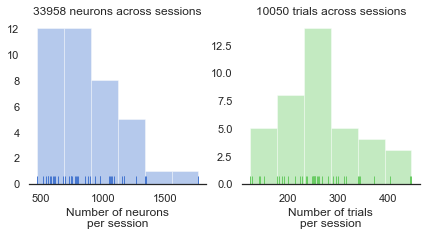

In [ ]:
summarise_dataset(alldat) # should be filtered data, but alldat is used here as an example


# Change the time bin
Optional step

In [ ]:
dat = first_session_filtered
NT = dat['spks'].shape[-1]
minT = 50
maxT = 130
NN = dat['spks'].shape[0]

droll = np.reshape(dat['spks'][:,:,minT:maxT], (NN,-1))

dat['spks'][:,:,minT:maxT].mean(axis=2).shape


(734, 10)

In [19]:
def neurons_time_PCA(dat,tVar,minT,maxT,toplot=False):
    #Perform PCA with the neurons of a single session. Components are estimated by considering activity in the range minT:maxT
    #Example input neurons_PCA(dat,0.9,51,130)

    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    NT = dat['spks'].shape[-1]

    #@title top PC directions from stimulus + response period, with projections of the entire duration
    NN = dat['spks'].shape[0]
    #All trials are concatenated to result in a session-long time series for each neuron:
    #droll = np.reshape(dat['spks'][:,:,minT:maxT], (NN,-1)) # first 80 bins = 1.6 sec
    #(N.B. only the time bins for stimulus + response are used!)

    #droll = droll - np.mean(droll, axis=1)[:, np.newaxis] #center each neuron's response vector
    #(np.newaxis is used to add an additional dimension, to be consistent with the original droll matrix)

    droll = reshaping_features(dat['spks']) #[:,:,minT:maxT].mean(axis=2)
    droll = droll.T
    nPCs = min(droll.shape) #set how many PCs we are interested in (all of them)

    model = PCA(n_components = nPCs).fit(droll.T) #perform PCA!
    weights = model.components_ #extract the weight of each PC dimension for each neuron
    PCneurons = weights @ droll #multiply each neuron by its corresponding weights
    #(N.B. the entire trial durations for each neuron are multiplied by the weight! But weight were extracted only from a portion)
    #PCneurons = np.reshape(PCneurons, (nPCs, -1, NT)) #session-long time series are split again into trial-long time series

    explVar = model.explained_variance_
    

    fracVar = explVar/np.sum(explVar) #fraction of explained variance for each PC
    cumVar = np.cumsum(fracVar) #cumulative sum of explained variance
    PCrange = np.max(np.where(cumVar<=tVar)) #The lowest number of components that explain the threshold variance
    
    if toplot == True:
        plt.figure()
        plt.bar(range(nPCs),explVar)
        plt.xlabel('Eigenvector')
        plt.ylabel('Explained variance')
        
        plt.plot([PCrange,PCrange],[0,np.max(explVar)],'r')

        #@title The top PCs capture most variance across the brain. What do they care about?
        plt.figure(figsize= (20, 6))
    
        for iPC in range((PCneurons).shape[0]):

          this_pc = PCneurons[iPC]

          plt.plot(this_pc.mean(axis=0))

          if iPC==0:
            plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
            plt.xlabel('binned time')
            plt.ylabel('Component value')
          # plt.title('PC %d'%j)

    dat['PCs'] = PCneurons
    dat['weights'] = weights
    dat['PCrange'] = PCrange+1

    return dat

# Filter, PCA, and Model one session

In [77]:
def rebin(dat, minT, maxT, newbin, oldbin = 0.01):
  ''' takes spike counts from 'spks' and rebins them into a new time bin specified by newbin

  Args:
  input = dict for the session (dat['spks'], dimensions: neurons * trials * time bins)
  newbin = size of the new time bin in seconds
  oldbin = size of old time bin. default 0.01s

  Returns:
  newcount = spike count in new bin
  newbin = size of new bin size
  '''

  #assert newbin > oldbin 'new bin size must be bigger than old bin size'
  input = dat['spks'][:,:,minT:maxT]
  # initialize variables
  poolbin = newbin/oldbin # calculates numbers of bins to be pooled into one new bin
  newcount = np.zeros((input.shape[0],input.shape[1],int(input.shape[2]/poolbin))) # create matrix of zeros with appropriate third dimension (number of bins)


  index = list(range(int(input.shape[2]/poolbin)))
  for idx in index:
      # sum up counts from one step to the next
      slc = input[:,:,int(idx*poolbin):int((idx+1)*poolbin)]
      newcount[:,:,idx] = np.sum(slc, axis=2)
  
  dat2 = dat.copy()
  dat2['spks'] = newcount

  return dat2 #newcount, newbin

In [105]:
filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
rebinned = rebin(filtered, 50, 250, 2)
rebinned['spks'].shape, filtered['spks'].shape

((0, 0, 1), (0, 0, 250))

In [134]:
probs[:,1]

array([0.45343092, 0.1079416 , 0.1152742 , 0.2005863 , 0.14442857,
       0.31069589, 0.68414395, 0.24833898, 0.72584557, 0.13238905,
       0.61238812, 0.41280501, 0.36661618, 0.70933953, 0.24217612,
       0.63032053, 0.15734123, 0.13828503, 0.63739845, 0.59220953,
       0.16024011, 0.70944127, 0.78592959, 0.72247484])

Number of PCs: 4
Accuracies: [0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Mean Accuracy: 0.2
Predictions: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Actual: [-1. -1.  1. -1. -1. -1. -1. -1.  1. -1.]
Probs: [[8.01980662e-08 9.99999920e-01]
 [7.22786649e-08 9.99999928e-01]
 [1.69417727e-07 9.99999831e-01]
 [7.51789994e-08 9.99999925e-01]
 [7.60066725e-08 9.99999924e-01]
 [7.79228745e-08 9.99999922e-01]
 [7.64792604e-08 9.99999924e-01]
 [7.59856165e-08 9.99999924e-01]
 [1.66872098e-07 9.99999833e-01]
 [7.61636345e-08 9.99999924e-01]]
Brier score: 7.999998779572525
Weight right: 0.2 weight left: 10000000.8
Percent Left: 0.2
Percent Right: 0.8


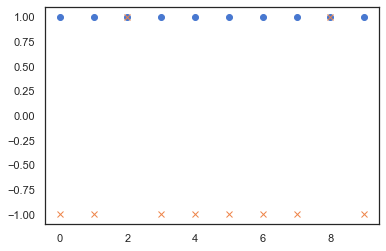

In [69]:
from sklearn.model_selection import *

session = 0
brain_areas = ["MOs"]


filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
#filtered = rebin(filtered, 50, 250, 2)
dat = neurons_PCA(filtered,0.9,50,250,toplot=False)
#dat['PCs'] = dat['PCs'][0:dat['PCrange'],:]

lambda_L2 = 1
penalty = "l2"
l1args = {}
left_bias = np.mean((filtered['chcs'])==1)
choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
w = {-1:left_bias, 1:(1-left_bias)}



logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args,class_weight=w).fit(dat['PCs'].T, filtered['chcs'])
splitter = LeaveOneOut()
splits = splitter.split(dat['PCs'].T)
accuracies=[]
predictions = []
probs = []
#Manual K-1 corss validation, saving predicitons:
for fit_trials,test_trial in splits:
    logreg.fit((dat['PCs'][:,fit_trials]).T, dat['chcs'][fit_trials])
    prediction = logreg.predict(dat['PCs'][:,test_trial].T)[0]
    prob = logreg.predict_proba(dat['PCs'][:,test_trial].T)[0]
    actual = dat['chcs'][test_trial][0]
    accuracy = int(actual == prediction)
    predictions.append(prediction)
    accuracies.append(accuracy)
    probs.append(prob)

probs = np.array(probs)
mprobs = [max(prob) for prob in probs]

print('Number of PCs: '+str(dat['PCrange']))

print('Accuracies: '+str(accuracies))
print('Mean Accuracy: '+str(np.mean(accuracies)))
print('Predictions: '+ str(predictions))
print('Actual: '+ str(filtered['chcs']))
print('Probs: '+ str(probs))
actual_choice_probs = [(prob[0] if choice==-1 else prob[1]) for prob,choice in zip(probs,filtered['chcs'])]
print('Brier score: '+str(np.sum((probs[:,1] - (filtered['chcs'] + 1)/2)**2)))
print('Weight right: '+str(w[-1])+' weight left: '+str(w[1]))
print('Percent Left: ' +str(np.mean((filtered['chcs'])==1)))
print('Percent Right: ' +str(np.mean((filtered['chcs'])==-1)))

plt.plot(predictions,linewidth=0,marker='o')
plt.plot(filtered['chcs'],linewidth=0,marker='x')



# Filter, PCA, and Model all sessions (with neurons)

In [78]:
allb = ['ACA','ACB','APN', 'AUD', 'BLA', 'BMA', 'CA', 'CA1', 'CA2', 'CA3', 'CL', 'COA',
 'CP','DG','DP','EP','EPd','GPe','IC' ,'ILA', 'LD', 'LGd' ,'LH', 'LP', 'LS',
 'LSc','LSr','MB','MD','MEA','MG','MOp','MOs','MRN','MS','NB','OLF','ORB',
 'ORBm','OT','PAG','PIR','PL','PO','POL','POST','PT','RN','RSP','RT',
 'SCig','SCm','SCs','SCsg','SI','SNr','SPF','SSp','SSs','SUB','TH','TT',
 'VAL','VISa','VISam','VISl','VISp','VISpm','VISrl','VPL','VPM','ZI']

brain_areas = ['MOs']
brain_areas = allb

for session in range(len(alldat)):
    if np.sum(np.isin(alldat[session]['brain_area'],brain_areas))>0:
        filtered = filter_spikes(alldat,session,unfair_only=False,chosey_only=True, nonzero_only=False,brain_area=brain_areas)
        #filtered = rebin(filtered, 50, 250, 2)
        dat = neurons_PCA(filtered,0.9,0,250)
       $ dat['PCs'] = dat['PCs'][0:dat['PCrange'],:]
        lambda_L2 = 1
        penalty = "none"
        l1args = {}
        left_bias = np.mean((filtered['chcs'])==1)
        choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
        w = {-1:left_bias, 1:(1-left_bias)}
       # l1args = {'solver':"saga", 'max_iter':5000}
        logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args)
        splitter = LeaveOneOut()
        splits = splitter.split(dat['PCs'].T)
        accuracies=[]
        predictions = []
        probs = []
        for fit_trials,test_trial in splits:
            logreg.fit((dat['PCs'][:,fit_trials]).T, dat['chcs'][fit_trials])
            prediction = logreg.predict(dat['PCs'][:,test_trial].T)[0]
            prob = logreg.predict_proba(dat['PCs'][:,test_trial].T)[0]
            actual = dat['chcs'][test_trial][0]
            accuracy = int(actual == prediction)
            predictions.append(prediction)
            accuracies.append(accuracy)
            probs.append(prob)   
        probs = np.array(probs)
        accuracies = np.array(accuracies)
        
        aob = accuracies.mean() - choice_bias
        print("Session# "+ str(session)+" accuracy = "+str(accuracies.mean())+" accuracy over bias = "+str(accuracies.mean() - choice_bias) + ", trial count= "+ str(len(accuracies)),"PC count= "+ str(dat['PCs'].shape[0]))

Session# 0 accuracy = 0.9357142857142857 accuracy over bias = [0.42857143], trial count= 140 PC count= 27
Session# 1 accuracy = 0.8471337579617835 accuracy over bias = [0.32484076], trial count= 157 PC count= 35
Session# 2 accuracy = 0.8211920529801324 accuracy over bias = [0.1986755], trial count= 151 PC count= 44
Session# 3 accuracy = 0.9186991869918699 accuracy over bias = [0.33333333], trial count= 123 PC count= 29
Session# 4 accuracy = 0.8266666666666667 accuracy over bias = [0.18], trial count= 150 PC count= 31
Session# 5 accuracy = 0.8434343434343434 accuracy over bias = [0.27272727], trial count= 198 PC count= 42
Session# 6 accuracy = 0.8789473684210526 accuracy over bias = [0.26842105], trial count= 190 PC count= 17
Session# 7 accuracy = 0.9426751592356688 accuracy over bias = [0.31210191], trial count= 157 PC count= 48
Session# 8 accuracy = 0.9789915966386554 accuracy over bias = [0.36554622], trial count= 238 PC count= 48
Session# 9 accuracy = 0.8767123287671232 accuracy ove

/Users/henryskelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/henryskelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

Session# 14 accuracy = 0.9120521172638436 accuracy over bias = [0.40390879], trial count= 307 PC count= 27
Session# 15 accuracy = 0.9029126213592233 accuracy over bias = [0.39320388], trial count= 206 PC count= 24
Session# 16 accuracy = 0.9186046511627907 accuracy over bias = [0.35465116], trial count= 172 PC count= 18
Session# 17 accuracy = 0.9416666666666667 accuracy over bias = [0.40416667], trial count= 240 PC count= 27
Session# 18 accuracy = 0.8148148148148148 accuracy over bias = [0.25925926], trial count= 135 PC count= 20
Session# 19 accuracy = 0.8085106382978723 accuracy over bias = [0.17730496], trial count= 141 PC count= 43
Session# 20 accuracy = 0.8382352941176471 accuracy over bias = [0.27941176], trial count= 68 PC count= 19
Session# 21 accuracy = 0.9604863221884499 accuracy over bias = [0.38905775], trial count= 329 PC count= 12
Session# 22 accuracy = 0.9069767441860465 accuracy over bias = [0.26744186], trial count= 86 PC count= 30
Session# 23 accuracy = 0.86538461538461

/Users/henryskelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/henryskelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

Session# 34 accuracy = 0.8189655172413793 accuracy over bias = [0.31034483], trial count= 232 PC count= 46
Session# 35 accuracy = 0.9041916167664671 accuracy over bias = [0.2994012], trial count= 167 PC count= 13
Session# 36 accuracy = 0.9137931034482759 accuracy over bias = [0.31896552], trial count= 116 PC count= 12


/Users/henryskelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/henryskelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

Session# 37 accuracy = 0.873015873015873 accuracy over bias = [0.1984127], trial count= 126 PC count= 15
Session# 38 accuracy = 0.8841201716738197 accuracy over bias = [0.27038627], trial count= 233 PC count= 32


# Filter, PCA, and Model w/ different time bins

In [ ]:
binl = 25
bins = [x for x in range(0,250,binl)]
brain_areas = ["MOp"]

for bin in bins:
    session = 10
    filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
    dat = neurons_PCA(filtered,0.9,bin,bin+binl)
    lambda_L2 = 1
    penalty = "l2"
    l1args = {}
    logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])
    splitter = LeaveOneOut()
    splits = splitter.split(dat['PCs'].T)
    accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=0) # k=8 crossvalidation
    print("Bin "+str(bin)+" to "+str(bin+binl)+" accuracy mean= "+str(accuracies.mean())+ ", percent left "+ str(np.mean((filtered['chcs'])==-1)))

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
[(session,np.sum(np.isin(alldat[session]['brain_area'],["VISam", "VISl", "VISp", "VISpm", "VISrl"])), np.sum(np.isin(alldat[session]['brain_area'],["ACB","CP"]))) for session in range(len(alldat))]

[(0, 178, 0),
 (1, 533, 0),
 (2, 228, 0),
 (3, 39, 0),
 (4, 0, 0),
 (5, 0, 0),
 (6, 0, 59),
 (7, 48, 0),
 (8, 142, 0),
 (9, 340, 0),
 (10, 0, 275),
 (11, 145, 0),
 (12, 34, 0),
 (13, 42, 0),
 (14, 0, 0),
 (15, 0, 0),
 (16, 0, 0),
 (17, 0, 313),
 (18, 179, 0),
 (19, 122, 0),
 (20, 0, 0),
 (21, 133, 92),
 (22, 190, 0),
 (23, 296, 0),
 (24, 94, 0),
 (25, 162, 0),
 (26, 103, 90),
 (27, 71, 0),
 (28, 0, 340),
 (29, 0, 0),
 (30, 0, 0),
 (31, 0, 0),
 (32, 0, 383),
 (33, 0, 0),
 (34, 75, 0),
 (35, 53, 0),
 (36, 77, 0),
 (37, 0, 0),
 (38, 141, 0)]

In [ ]:
aba = []
for session in alldat:
    for ba in session['brain_area']:
        if ba not in aba:
            aba.append(ba)
            
print(np.sort(aba))

['ACA' 'ACB' 'APN' 'AUD' 'BLA' 'BMA' 'CA' 'CA1' 'CA2' 'CA3' 'CL' 'COA'
 'CP' 'DG' 'DP' 'EP' 'EPd' 'GPe' 'IC' 'ILA' 'LD' 'LGd' 'LH' 'LP' 'LS'
 'LSc' 'LSr' 'MB' 'MD' 'MEA' 'MG' 'MOp' 'MOs' 'MRN' 'MS' 'NB' 'OLF' 'ORB'
 'ORBm' 'OT' 'PAG' 'PIR' 'PL' 'PO' 'POL' 'POST' 'PT' 'RN' 'RSP' 'RT'
 'SCig' 'SCm' 'SCs' 'SCsg' 'SI' 'SNr' 'SPF' 'SSp' 'SSs' 'SUB' 'TH' 'TT'
 'VAL' 'VISa' 'VISam' 'VISl' 'VISp' 'VISpm' 'VISrl' 'VPL' 'VPM' 'ZI'
 'root']


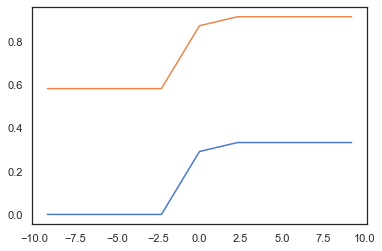

In [ ]:
lams = np.logspace(-4,4,num=9)
aobs = []
accs = []
for lam in lams:
    session = 10
    filtered = filter_spikes(alldat,session,unfair_only=True,chosey_only=True, nonzero_only=True,brain_area=brain_areas)
    dat = neurons_PCA(filtered,0.9,0,250)
    lambda_L2 = lam
    penalty = "l2"
    l1args = {}
    logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])
    splitter = LeaveOneOut()
    splits = splitter.split(dat['PCs'].T)
    accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=0) # k=8 crossvalidation
    left_bias = np.mean((filtered['chcs'])==-1)
    choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
    aob = accuracies.mean() - choice_bias
    aobs.append(aob)
    accs.append(accuracies.mean())
plt.plot(np.log(lams),aobs)
plt.plot(np.log(lams),accs)